In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import IPython
import librosa
import librosa.display
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold


%matplotlib inline

COMPLETE_RUN = True
data_path = '../data'

In [2]:
train_curated = pd.read_csv(data_path + "/train_curated.csv")

In [3]:
test = pd.read_csv(data_path + "/sample_submission.csv")

In [66]:
train_curated.sample(5)

'0006ae4e.wav'

In [5]:
test.sample()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
355,156c1736.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print("Number of train curated examples=", train_curated.shape[0], "  Number of classes=", len(set(train_curated['labels'])))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))

Number of train noisy examples= 4970   Number of classes= 213
Number of test examples= 1120   Number of classes= 80


In [7]:
train_curated = train_curated[train_curated['labels'].isin(test.columns[1:])]
print(len(train_curated))

4269


In [8]:
print("Curated dataset lost %{:.1f}".format((19815 - 16566)/19815 * 100))

Noisy dataset lost %16.4


In [9]:
print("Number of train curated examples=", train_curated.shape[0], "  Number of classes=", len(set(train_curated['labels'])))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))

Number of train noisy examples= 4269   Number of classes= 74
Number of test examples= 1120   Number of classes= 80


In [10]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


class Conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    n_folds=10
    max_epochs=50
    learning_rate=0.0001
    n_classes = 80
    dim = (256, 256, 3)

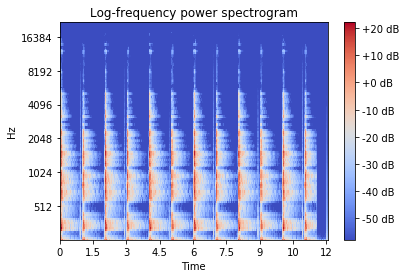

In [11]:
# example
x1 = read_as_melspectrogram(Conf, data_path + '/train_curated/69701771.wav', trim_long_data=False, debug_display=True)

In [12]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source, img_dest):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(Conf, source + '/' + str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    # img_dest unused for now
    return X

In [13]:
train_curated_path = data_path + '/train_curated'
test_path = data_path + '/test'
test_images_path = data_path + '/test_images'

X_train_curated = convert_wav_to_image(train_curated, source=train_curated_path)
X_test = convert_wav_to_image(test, source=test_path)

In [ ]:
def open_audio(file_path, ):
    # Read and Resample the audio
    data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate, res_type='kaiser_fast')

    # Random offset / Padding
    if len(data) > input_length:
        max_offset = len(data) - input_length
        offset = np.random.randint(max_offset)
        data = data[offset:(input_length+offset)]
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)
            offset = np.random.randint(max_offset)
        else:
            offset = 0
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

In [14]:
import PIL
import random

NOS_X_FILES, NOS_X = list(train_curated.fname.values), X_train_curated
TEST_X_FILES, TEST_X = list(test.fname.values), X_test

# def pil2tensor(image, dtype):
#     a = np.asarray(image)
#     if a.ndim==2 : a = np.expand_dims(a,2)    
#     a = np.transpose(a, (1, 0, 2))  #transpose width, height to height,width
#     a = np.transpose(a, (2, 1, 0))  #move channels to the first positionf
#     return a.astype(dtype, copy=False)
#     # return torch.from_numpy( a.astype(dtype, copy=False) )

def open_image(fn, images)->PIL.Image:
    filename = fn.split('/')[-1]
    idx = images.index(filename)
    x = PIL.Image.fromarray(NOS_X[idx])
    time_dim, base_dim = x.size
    return x.resize((256,256))

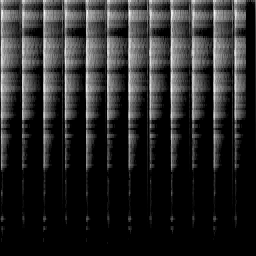

In [15]:
open_image(data_path + '/train_curated/69701771.wav', NOS_X_FILES)

In [16]:
from keras import losses, models, optimizers
from keras.layers import (Input, Dense, Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K
from keras.callbacks import (EarlyStopping, ModelCheckpoint, TensorBoard)
from keras.activations import relu, softmax

category_group = train_curated.groupby(['labels']).count()
category_group.columns = ['counts']
print(len(category_group))

COMPLETE_RUN = False

category_group.head()

Using TensorFlow backend.


74


,counts
labels,
Accelerating_and_revving_and_vroom,32
Accordion,47
Acoustic_guitar,3
Bark,69
Bass_drum,68


In [60]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],config.dim[2]))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [18]:
LABELS = list(train_curated['labels'].unique())
label_idx = {label: i for i, label in enumerate(LABELS)}

In [53]:
%time
X_train_curated_prepared = prepare_data(train_curated, Conf, data_path + '/train_curated/', NOS_X_FILES)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [55]:
X_test_prepared = prepare_data(test, Conf, data_path + '/test/', TEST_X_FILES)

In [56]:
_train_curated = train_curated.copy().set_index("fname")
_train_curated["label_idx"] = _train_curated['labels'].apply(lambda x: label_idx[x])

y_train = to_categorical(_train_curated.label_idx.astype('str'), num_classes=Conf.n_classes)

In [61]:
# Training 2D Conv on Mel-Spectogram

PREDICTION_FOLDER = "predictions_2d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(n_splits=Conf.n_folds)

for i, (train_split, val_split) in enumerate(skf.split(_train_curated.index, _train_curated.label_idx)):
    K.clear_session()
    X, y, X_val, y_val = X_train_curated_prepared[train_split], y_train[train_split], X_train_curated_prepared[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(Conf)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=Conf.max_epochs)
    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


##################################################
Fold:  0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3806 samples, validate on 463 samples
Epoch 1/50
3806/3806 [==============================] - 1143s 300ms/step - loss: 4.2010 - acc: 0.0720 - val_loss: 3.8886 - val_acc: 0.1296

Epoch 00001: val_loss improved from inf to 3.88855, saving model to best_0.h5
Epoch 2/50
3806/3806 [==============================] - 1143s 300ms/step - loss: 3.6412 - acc: 0.2039 - val_loss: 3.8193 - val_acc: 0.1641

Epoch 00002: val_loss improved from 3.88855 to 3.81926, saving model to best_0.h5
Epoch 3/50
3806/3806 [==============================] - 1142s 300ms/step - loss: 3.3543 - acc: 0.3129 - val_loss: 3.4937 - val_acc: 0.2678

Epoch 00003: val_loss improved from 3.81926 to 3.49372, saving model to best_0.h5
Epoch 4/50
3806/3806 [==============================] - 1143s 300ms/step - loss: 3.1257 - acc: 0.3915 - val_los

3806/3806 [==============================] - 1136s 298ms/step - loss: 0.1772 - acc: 0.9992 - val_loss: 2.6079 - val_acc: 0.4233

Epoch 00036: val_loss did not improve from 2.60625
Epoch 37/50
3806/3806 [==============================] - 1136s 299ms/step - loss: 0.1672 - acc: 0.9992 - val_loss: 2.6060 - val_acc: 0.4147

Epoch 00037: val_loss improved from 2.60625 to 2.60604, saving model to best_0.h5
Epoch 38/50
3806/3806 [==============================] - 1139s 299ms/step - loss: 0.1524 - acc: 0.9995 - val_loss: 2.6013 - val_acc: 0.4125

Epoch 00038: val_loss improved from 2.60604 to 2.60129, saving model to best_0.h5
Epoch 39/50
1920/3806 [==============>...............] - ETA: 9:05 - loss: 0.1382 - acc: 1.0000

KeyboardInterrupt: 